<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter2/Chapter2_2_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 준비

In [6]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/jpub-dongdong9/TimeSeriesForecastingInPython/refs/heads/master/data/jj.csv')
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


훈련 데이터 집합은 1960년부터 시작하여 1979년 말까지이고, 1980년에 수집된 데이터는 테스트 데이터 집합으로 가정해보자

In [7]:
train = df[:-4]
test = df[-4:]

In [8]:
test

,date,data
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [9]:
train

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
75,1978-10-01,8.91
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85


# 2. 베이스라인 모델 구현

## 과거 평균으로 예측하기

In [11]:
import numpy as np

historical_mean = train['data'].mean()
# or historical_mean = np.mean(train['data'])
historical_mean

4.308499987499999

In [14]:
test.loc[:,'pred_mean'] = historical_mean
test

<ipython-input-14-66162f324d82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_mean'] = historical_mean


,date,data,pred_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


### 평가지표 : 평균절대백분율오차MAPE

In [15]:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_hist_mean = mape(test['data'], test['pred_mean'])
mape_hist_mean

70.00752579965119

MAPE가 70.00%라는 것은 관측된 존슨앤드존슨의 분기별 주당순이익 실젯값에 비해 평균적으로 70% 정도 벗어나는 결과를 보인다는 것을 뜻한다.  
이 예측값들을 시각화해보자

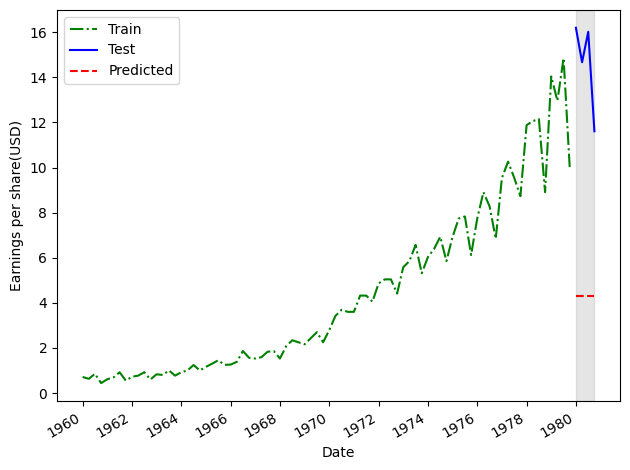

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label = 'Train')

ax.plot(test['date'], test['data'], 'b-', label = 'Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label = 'Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share(USD)')
ax.axvspan(80,83, color = '#808080', alpha = 0.2)
ax.legend()

plt.xticks(np.arange(0,85,8),[1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

## 작년의 평균으로 예측하기
1979년의 평균 EPS를 계산하여 1980년의 각 분기를 예측해보자.  

In [45]:
last_year_mean = np.mean(train[-4:]['data'])
last_year_mean

12.96

In [47]:
test.loc[:,'pred__last_yr_mean'] = last_year_mean
test

,date,data,pred_mean,pred__last_yr_mean
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-02,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


In [48]:
mape_last_year_mean = mape(test['data'], test['pred__last_yr_mean'])
mape_last_year_mean

15.5963680725103

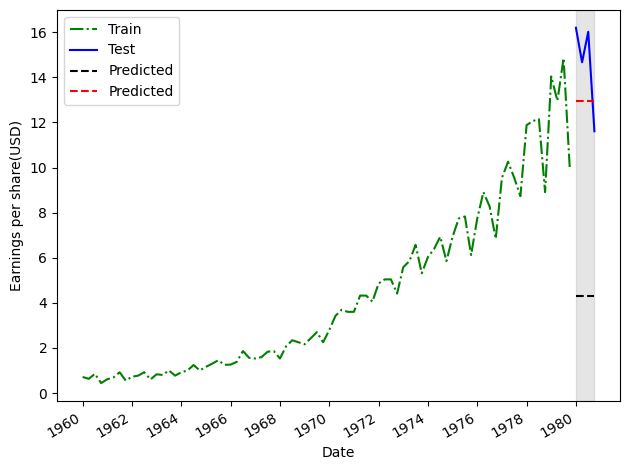

In [53]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label = 'Train')

ax.plot(test['date'], test['data'], 'b-', label = 'Test')
ax.plot(test['date'], test['pred_mean'], 'k--', label = 'Predicted')
ax.plot(test['date'], test['pred__last_yr_mean'], 'r--', label = 'Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share(USD)')
ax.axvspan(80,83, color = '#808080', alpha = 0.2)
ax.legend()

plt.xticks(np.arange(0,85,8),[1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

이번 베이스라인 모델을 통해 미래의 값이 너무 멀지 않은 과것값과 연관이 있을 가능성이 높다는 점을 알 수 있었다. 이는 자기상관관계(autocorrelation)의 징조이다.


## 마지막으로 측정된 값으로 예측하기
위의 두 베이스라인 모델을 통해 미랫값은 과것값과 연관이 있지만 너무 먼 과것값과는 연관성이 떨어진다는 점을 알게 되었다.  
따라서 훈련 집합 중 마지막으로 측정된 값을 베이스라인 모델로 사용한다면 더 나은 예측을 얻을 수 있고, 0%에 가까운 MAPE를 얻을 수 있을 것이라는 가설을 세워 보자

In [63]:
last = train.data.iloc[-1]
last

9.99

In [64]:
test.loc[:,'pred_last'] = last
test

,date,data,pred_mean,pred__last_yr_mean,pred_last
80,1980-01-01,16.20,4.3085,12.96,9.99
81,1980-04-01,14.67,4.3085,12.96,9.99
82,1980-07-02,16.02,4.3085,12.96,9.99
83,1980-10-01,11.61,4.3085,12.96,9.99


In [65]:
mape_last = mape(test['data'], test['pred_last'])
mape_last

30.457277908606535

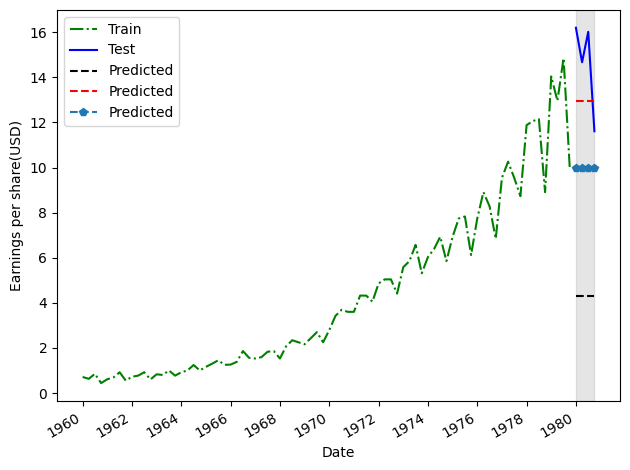

In [66]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label = 'Train')

ax.plot(test['date'], test['data'], 'b-', label = 'Test')
ax.plot(test['date'], test['pred_mean'], 'k--', label = 'Predicted')
ax.plot(test['date'], test['pred__last_yr_mean'], 'r--', label = 'Predicted')
ax.plot(test['date'], test['pred_last'], 'p--', label = 'Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share(USD)')
ax.axvspan(80,83, color = '#808080', alpha = 0.2)
ax.legend()

plt.xticks(np.arange(0,85,8),[1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

이번 베이스라인 모델에 의한 새로운 예측은 1980년 관측값과 차이가 더 크다.  
이러한 결과는 EPS가 처음 3번의 분기 동안은 높았다가 마지막 분기에 하락하는 주기적인 행동을 보인다는 점을 그 원인으로 볼 수 있다.  
마지막으로 측정된 값을 사용하는 겨우 계절성을 반영하지 않아 좋지 않은 결과에 도달한 것이므로, 더 나은 베이스라인 모델을 생성하기 위해 또 다른 단순한 예측 기법을 사용해보자.  


## 단순한 계절적 예측 구현하기
단순한 계절적 예측 방법은 마지막으로 측정된 주기가 미래에도 반복된다는 것이다.  
이번 예시에서 주기의 길이는 4번의 분기이므로, 1979년 첫 번째 분기의 EPS를 사용하여 1980년 첫 번째 분기의 값을 예측하고, 1979년 두 번쨰 분기의 EPS를 사용하여 1980년 두 번째 분기의 값을 예측하는 형식으로 해보자.  

In [68]:
test.loc[:,'pred_last_season'] = train['data'][-4:].values
test

,date,data,pred_mean,pred__last_yr_mean,pred_last,pred_last_season
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [69]:
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
mape_naive_seasonal

11.561658552433654

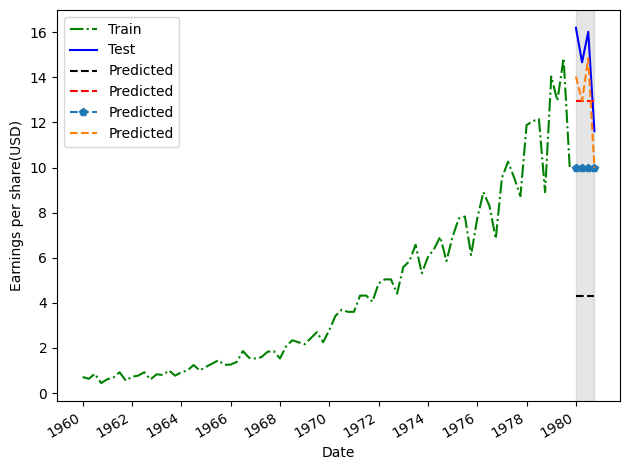

In [76]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label = 'Train')

ax.plot(test['date'], test['data'], 'b-', label = 'Test')
ax.plot(test['date'], test['pred_mean'], 'k--', label = 'Predicted')
ax.plot(test['date'], test['pred__last_yr_mean'], 'r--', label = 'Predicted')
ax.plot(test['date'], test['pred_last'], 'p--', label = 'Predicted')
ax.plot(test['date'], test['pred_last_season'], '--', label = 'Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share(USD)')
ax.axvspan(80,83, color = '#808080', alpha = 0.2)
ax.legend()

plt.xticks(np.arange(0,85,8),[1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

위의 4가지 베이스라인의 MAPE를 정리하면 다음과 같다

In [78]:
baseline = ['hist_mean','last_year_mean','last','naive_seasonal']
mapes = [mape_hist_mean,mape_last_year_mean,mape_last,mape_naive_seasonal]
df_mape = pd.concat([pd.DataFrame(baseline), pd.DataFrame(mapes)], axis = 1)
df_mape.columns = ['baseline', 'mape']
df_mape

,baseline,mape
0,hist_mean,70.007526
1,last_year_mean,15.596368
2,last,30.457278
3,naive_seasonal,11.561659


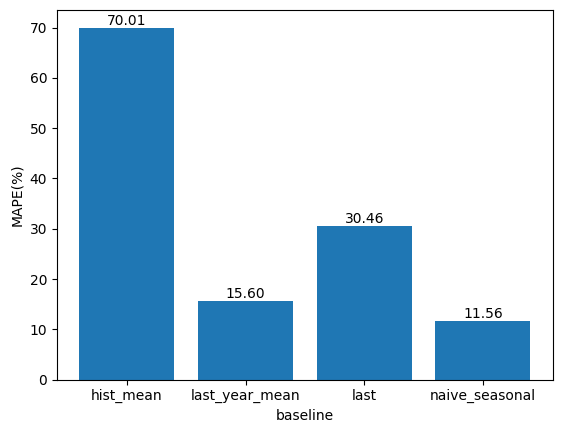

In [85]:
plt.bar(df_mape.baseline, df_mape.mape)

for i, value in enumerate(df_mape.mape):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylabel('MAPE(%)')
plt.xlabel('baseline')
plt.show()